# Adaptive Shot Allocation for Expectation Value Calculations - Part 2

## Overview

In Part 1, we explored the basics of shot allocation for expectation value calculations in quantum computing and demonstrated why intelligent allocation strategies matter. We compared uniform and coefficient-weighted approaches and showed that an optimal strategy needs to consider both the Hamiltonian coefficient magnitudes and measurement variances for the particular quantum state.

However, we faced a fundamental challenge: the optimal strategy requires knowing the measurement variances beforehand, which isn't possible in real applications. This is where adaptive shot allocation comes in.

In this notebook, we'll take the next step by implementing and evaluating an adaptive shot allocation strategy that dynamically adjusts based on measurement results. You will learn:

- How adaptive shot allocation works and why it solves the "chicken and egg" problem
- How to implement an adaptive allocator that learns from measurements
- How to compare different allocation strategies in realistic scenarios
- How to apply these techniques to complex Hamiltonians from quantum chemistry

Our implemtenation is based on "Adaptive Estimation of Quantum Observables" by Shlosberg et al. (http://dx.doi.org/10.22331/q-2023-01-26-906)

## 1. From Static to Adaptive Allocation

In Part 1, we showed that the optimal static shot allocation strategy should distribute shots proportionally to:

$$ |c_i|\sqrt{\mathbb{Var}(\mathbf{P}_i)} $$

where $c_i$ is the coefficient and $\mathbb{Var}(\mathbf{P}_i)$ is the variance of measurements for term $i$.

However, there's a fundamental challenge: we don't know the variances in advance! This creates a "chicken and egg" problem:
- To allocate shots optimally, we need to know the variances
- To estimate the variances, we need to take shots

This is where adaptive allocation comes in. Instead of deciding all shot allocations upfront, we use an iterative approach:

1. Start with an initial allocation (e.g., uniform or coefficient-weighted)
2. Take measurements and estimate the variances
3. Reallocate remaining shots based on these estimates
4. Repeat until all shots are used

This approach, based on the paper ["Adaptive Shot Allocation for Fast Convergence in Variational Quantum Algorithms"](https://arxiv.org/abs/2110.15339), can significantly outperform static strategies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

from braket.experimental.algorithms.adaptive_shot_allocation.adaptive_allocator import AdaptiveShotAllocator

from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm

The core component of our implementation is the `AdaptiveShotAllocator` class, which implements the adaptive shot allocation strategy. This allocator performs several key functions:

1. Groups compatible Pauli terms that can be measured simultaneously
2. Tracks measurement outcomes and updates variance/covariance estimates
3. Estimates the variance contribution of each group to the total error
4. Dynamically allocates shots to the groups to minimize the overall estimation error

The grouping of compatible terms is particularly important as it allows us to extract more information from each quantum circuit execution, effectively getting "free" measurements of correlated terms.

Before we import some helper functions and apply this to more complicated Hamiltonians, let's demonstrate the basic usage of the class with our simple two-qubit Hamiltonian from Part 1.

Recall the Hamiltonian from Part 1:

$$ \mathbf{H} = IZ + ZI + 10 \times XX $$

When acting on the uniform superposition state, this Hamiltonian has an interesting property: the $XX$ term has zero variance (the state is an eigenstate of $XX$), while the $IZ$ and $ZI$ terms have maximum variance without being correlated. In Part 1, we showed that the coefficient-weighted shot-allocation strategy performs uncharacteristically poorly here, wasting measurements on the $XX$ term which has zero variance.

This example will help us demonstrate how the adaptive allocator can learn this property and adjust its allocation strategy accordingly, even without prior knowledge of the state's properties.

In [2]:
paulis = ["IZ", "ZI", "XX"]
coeffs = [1.0, 1.0, 10.0]

estimator = AdaptiveShotAllocator(paulis, coeffs)

print("Identified commuting groups:", [ [paulis[p] for p in commuting_group] for commuting_group in estimator.cliq])

print("Proposed allocation (shots per group) w/o prior measurement knowledge: ",  estimator.incremental_shot_allocation(1200))

Identified commuting groups: [['IZ', 'ZI'], ['XX']]
Proposed allocation (shots per group) w/o prior measurement knowledge:  [149, 1051]


As expected, without any prior measurement knowledge the allocator would propose more shots on the second group (the $XX$ term), since any error incurred there (in the single-term expectation value estimation) would be magnified ten-fold. However, we could divide our available budget (say, in 12 rounds of 100 shots) and help the allocator. 

For the purposes of this demonstration, and since we're working with the uniform-superposition state, we'll just simulate taking measurements by casting a four-sided die. But do not worry, we'll show you how to run this on a Braket device as well!

In [3]:
estimator.reset()
hamiltonian_terms = len(paulis)

for round_id in range(12):
    # STEP 1: Get the proposed shot allocation for our next 100 shots.
    shots = estimator.incremental_shot_allocation(100)
    print(f"Proposed shot allocation for round {round_id}: {shots}")

    # We need statistics for terms measured together, since their measurements are no-longer uncorrelated.
    # To that end, we keep track of the measurements in a 2-D array, recording the number of different outcomes.
    measurements = [[{(1, 1): 0, (1, -1): 0, (-1, 1): 0, (-1, -1): 0}
                            for _ in range(hamiltonian_terms)]
                            for _ in range(hamiltonian_terms)]

    # STEP 2: Perform the measurements ()
    for shot_id in range(shots[0]):
        state = np.random.randint(4)
        measurement_IZ = 1 - 2*(state%2)
        measurement_ZI = 1 - 2*(state//2)
        measurements[0][0][(measurement_IZ, measurement_IZ)] += 1
        measurements[1][1][(measurement_ZI, measurement_ZI)] += 1
        measurements[0][1][(measurement_IZ, measurement_ZI)] += 1
        measurements[1][0][(measurement_ZI, measurement_IZ)] += 1    
    
    for shot_id in range(shots[1]):
        measurement_XX = 1
        measurements[2][2][(measurement_XX, measurement_XX)] += 1

    # STEP 3: Update the estimator by providing the new measurement outcomes.
    estimator.update_measurements(measurements)

print("\nShots taken: ")
print(f"    {estimator.shots[0]} for {[paulis[p] for p in estimator.cliq[0]]}")
print(f"    {estimator.shots[1]} for {[paulis[p] for p in estimator.cliq[1]]}")

Proposed shot allocation for round 0: [13, 87]
Proposed shot allocation for round 1: [63, 37]
Proposed shot allocation for round 2: [56, 44]
Proposed shot allocation for round 3: [60, 40]
Proposed shot allocation for round 4: [61, 39]
Proposed shot allocation for round 5: [63, 37]
Proposed shot allocation for round 6: [65, 35]
Proposed shot allocation for round 7: [66, 34]
Proposed shot allocation for round 8: [67, 33]
Proposed shot allocation for round 9: [68, 32]
Proposed shot allocation for round 10: [69, 31]
Proposed shot allocation for round 11: [69, 31]

Shots taken: 
    720 for ['IZ', 'ZI']
    480 for ['XX']


Now this is much better. We ended-up allocating more of the available budget to the terms that matter. Note that since the measurements have already been perfromed and our allocator has kept track of them, we have the approximated expectation value. In addition, since it has kept track of the (estimated) terms variance/covariance values, we can also get an estimate of the statistical error.

In [4]:
print(f"Estimated expectation value: {estimator.expectation_from_measurements():.6f} ± {estimator.error_estimate():.6f}")

Estimated expectation value: 10.080556 ± 0.067008


## 3. Helper Functions

The workflow demonstrated above is so common for the adaptive shot allocation that we have a helper function that does it for us. Below we import two functions for performing measurements - running a fixed allocation (specifying shots per group), and running adaptive allocation (specifyinng shots per round and number of rounds).

In [5]:
# Functions for executing measurements with different allocation strategies
from braket.experimental.algorithms.adaptive_shot_allocation.adaptive_allocator_braket_helpers import (
    run_fixed_allocation,
    run_adaptive_allocation
)

For the benchmarking puproses below we also need to be able to create random states and compute exact expectation values (under the hood, we use the `LocalSimulator` for this purpose).

In [6]:
from adaptive_allocation_notebook_helpers import create_random_state, get_exact_expectation

Finally, we'll import functions implementing different shot allocation strategies.

In [7]:
# Functions for static shot allocation strategies
from adaptive_allocation_notebook_helpers import get_uniform_shots, get_random_shots, get_weighted_shots

# Examples of different static allocations for 7 measurement groups with 1000 total shots
print("Uniform allocation for 7 groups, 1000 shots:")
print(get_uniform_shots(7, 1000))

print("\nRandom allocation for 7 groups, 1000 shots:")
print(get_random_shots(7, 1000))

Uniform allocation for 7 groups, 1000 shots:
[143, 143, 143, 143, 143, 143, 142]

Random allocation for 7 groups, 1000 shots:
[105, 254, 62, 200, 168, 78, 133]


## 4. A Realistic Aplication
Moving beyond our simple two-qubit example, let's apply our methods to a realistic quantum chemistry problem: the 4-qubit Beryllium monohydride (BeH) electronic structure Hamiltonian. 

This example will demonstrate how our adaptive allocation strategy performs on a more complex problem with more terms than our simple test case.

In [8]:
# Note that, as would be the case in practice, we have removed the IIII term and its cofficient from the calculations below
paulis = ['IIII', 'XXXI', 'XXXZ', 'XYYI', 'XZXI', 'XZXZ', 'YXYI', 'YXYZ', 'YYXI', 'YZYI', 'YZYZ', 'ZIII',
          'ZXZI', 'ZXZZ', 'ZXIZ', 'ZZII', 'ZZZI', 'ZZZZ', 'ZIZI', 'ZIZZ', 'IXII', 'IXZI', 'IXIZ', 'IZII',
          'IZZZ', 'IZIZ', 'IIZI'][1:]
coeffs = [-14.440090444958097, 0.01396784712709576, 0.0050449972385411684, 0.008922759379312662, 0.004572316311895031, 
          0.004572316311895031, 0.01396784712709576, 0.0050449972385411684, -0.008922759379312662, 0.004572316311895031, 
          0.004572316311895031, 0.37322478932293823, 0.01396784712709576, 0.0050449972385411684, -0.008922759379312663, 
          0.37322478932293823, 0.06754531038829523, 0.06754531038829523, 0.0629729940764002, 0.0629729940764002, 
          -0.0050449972385411684, 0.008922759379312663, -0.01396784712709576, 0.1377331477309217, 0.18592768458263145, 
          0.10062930161995226, 0.18592768458263148][1:]

print(f"4-qubit BeH Hamiltonian (electronic, Bravyi-Kitaev mapping).")
print(f"Number of qubits: {len(paulis[0])}")
print(f"Number of terms: {len(paulis)}")

4-qubit BeH Hamiltonian (electronic, Bravyi-Kitaev mapping).
Number of qubits: 4
Number of terms: 26


For this Hamiltonian, we'll evaluate the expectation value with respect to a random quantum state, similar to what would be encountered during a variational quantum eigensolver (VQE) optimization. We've chosen the real-amplitudes ansatz, which is a hardware-efficient parameterized circuit commonly used in VQE applications.

In [9]:
# Create the appropriate quantum state
circuit = create_random_state(num_qubits=len(paulis[0]))
print("\nCircuit generating a random state with real amplitudes (4 qubits):")
print(circuit)


Circuit generating a random state with real amplitudes (4 qubits):
T  : │     0      │  1  │     2      │     3      │     4      │
      ┌──────────┐       ┌──────────┐                           
q0 : ─┤ Ry(2.52) ├───●───┤ Ry(0.08) ├───────────────────────────
      └──────────┘   │   └──────────┘                           
      ┌──────────┐ ┌─┴─┐              ┌──────────┐              
q1 : ─┤ Ry(0.95) ├─┤ X ├──────●───────┤ Ry(0.97) ├──────────────
      └──────────┘ └───┘      │       └──────────┘              
      ┌──────────┐          ┌─┴─┐                  ┌──────────┐ 
q2 : ─┤ Ry(2.71) ├──────────┤ X ├──────────●───────┤ Ry(1.07) ├─
      └──────────┘          └───┘          │       └──────────┘ 
      ┌──────────┐                       ┌─┴─┐     ┌──────────┐ 
q3 : ─┤ Ry(1.25) ├───────────────────────┤ X ├─────┤ Ry(2.21) ├─
      └──────────┘                       └───┘     └──────────┘ 
T  : │     0      │  1  │     2      │     3      │     4      │


## 5. Implementing Adaptive Shot Allocation

Now let's instantiate our `AdaptiveShotAllocator` and put it to work. The allocator first constructs a graph, where the Pauli terms are the graph nodes, and two terms are connected by an edge if they (qubitwise) commute. The graph is then partitioned into non-overlapping "cliques" - sub-graphs where every two distinct vertices are connected. These cliques naturally form groups of Pauli terms that can be measured together.

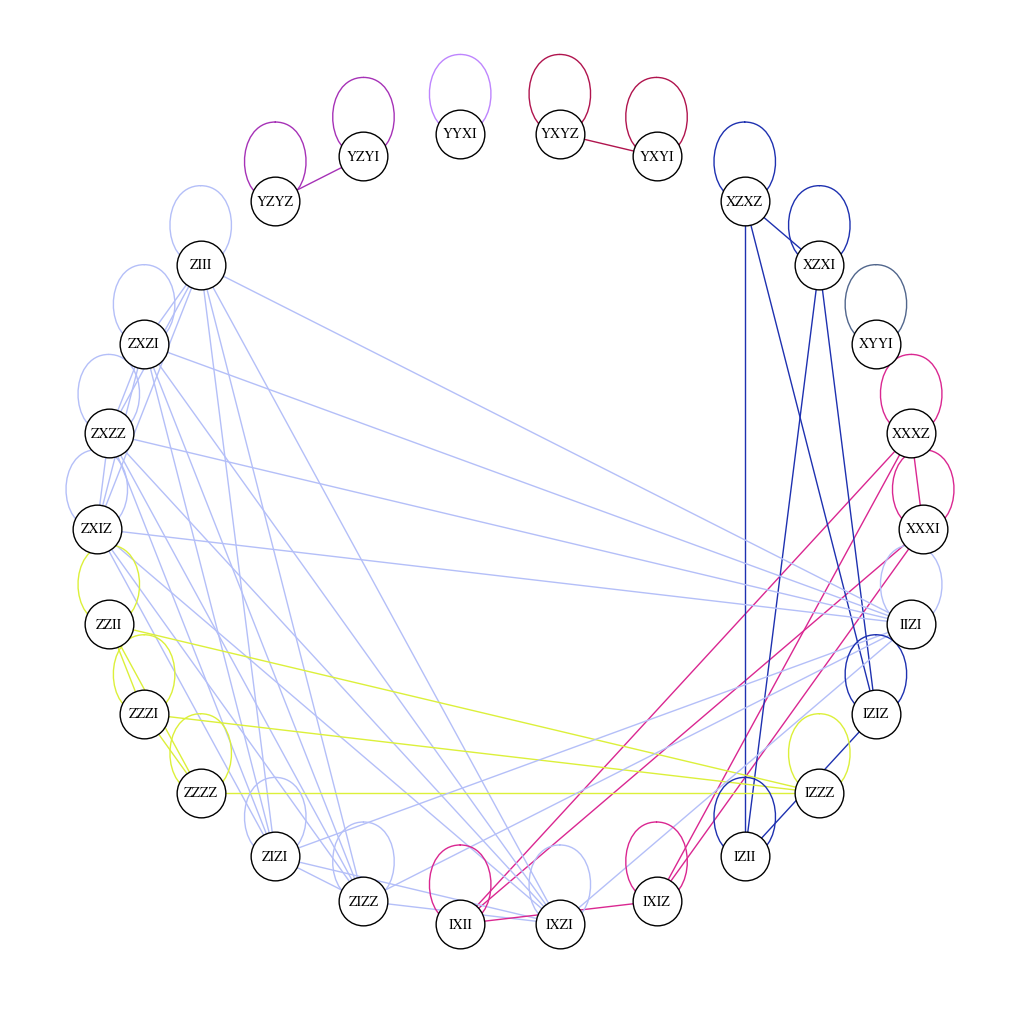


Number of cliques: 8
Cliques: [[10, 11, 12, 13, 17, 18, 20, 25], [0, 1, 19, 21], [3, 4, 22, 24], [14, 15, 16, 23], [5, 6], [8, 9], [2], [7]]


In [10]:
# Create the adaptive shot allocator
estimator = AdaptiveShotAllocator(paulis, coeffs)

# Visualize the grouping of Pauli terms
estimator.visualize_graph(show_cliques=True)
print(f"\nNumber of cliques: {len(estimator.cliq)}")
print(f"Cliques: {estimator.cliq}")

The visualization above shows how the Pauli terms are grouped into cliques (sets of terms that can be measured simultaneously). Each clique represents a set of Pauli terms that commute with each other and can therefore be measured in the same basis. This grouping reduces the number of distinct measurements needed, as we don't need to prepare a separate circuit for each term.

Now, let's calculate the exact expectation value for reference and run our adaptive estimation:

In [11]:
device = LocalSimulator()

# Calculate exact expectation value
e_exact = get_exact_expectation(circuit, paulis, coeffs)
print(f"Exact expectation value: {e_exact:.6f}")

# Run adaptive estimation
shots_per_round = 500
num_rounds = 10
total_shots = shots_per_round * num_rounds

print(f"\nRunning adaptive estimation:")
final_measurements = run_adaptive_allocation(
    device, circuit, estimator, shots_per_round, num_rounds, True
)

e_estimated = estimator.expectation_from_measurements()
error_estimate = estimator.error_estimate()

print("\nAdaptive Results:")
print(f"Estimated expectation: {e_estimated:.6f}")
print(f"Estimated standard error: {error_estimate:.6f}")

print(f"Actual difference: {abs(e_exact - e_estimated):.6f} ({100*abs(e_exact - e_estimated)/abs(e_exact):.2f}%)")
print(f"Final shot allocation: {estimator.shots}")
print(f"Total shots used: {sum(estimator.shots)}")

Exact expectation value: -0.209513

Running adaptive estimation:
Running 10 rounds with 500 shots each:
Round 1/10...
Round 2/10...
Round 3/10...
Round 4/10...
Round 5/10...
Round 6/10...
Round 7/10...
Round 8/10...
Round 9/10...
Round 10/10...

Adaptive Results:
Estimated expectation: -0.195694
Estimated standard error: 0.012057
Actual difference: 0.013818 (6.60%)
Final shot allocation: [1691, 117, 854, 2113, 87, 36, 50, 52]
Total shots used: 5000


**NOTE**: We can re-run the above cell a few more times and see how the standard error (and, hopefully, the observed actual error) decrease further. This is because the estimator will keep track of all previous measurements unless we specifically call `estimator.reset()`.

### 5.1 Efficiency Considerations
An important aspect of the adaptive shot allocation algorithm is the trade-off between computational efficiency and improved accuracy.
Proposing new allocations based on current statistical estimates is very fast - the algorithm simply uses the computed variance estimates to propose the optimal allocation for the next batch of shots. The time-consuming part of the process is performing the actual quantum measurements and updating the statistics. This is where most of the runtime is spent, as it involves executing quantum circuits and processing the results.

The key parameter we have control over for runtime optimization is how frequently we perform this update cycle. This creates a spectrum of possible approaches:

- At one extreme, we could allocate all shots at once without any intermediate updates. This is equivalent to running a fixed (weighted) allocation strategy and is computationally efficient but will not provide an uplift in accuracy.

- At the other extreme, we could allocate shots one by one, performing measurements and updating statistics after each shot. While this would provide the most responsive adaptation, it would be prohibitively expensive due to the overhead of executing separate measurement tasks in serial.

- The implementation above strikes a balance by using "rounds" of measurements (demonstrated with `num_rounds` and `shots_per_round`), allowing us to adapt periodically without incurring excessive overhead.

This trade-off between adaptation frequency and computational efficiency is an important consideration when implementing adaptive shot allocation in practice. The optimal choice depends on factors such as the quantum hardware being used, the complexity of the Hamiltonian, and the available computational resources.

## 6. Comparing Allocation Strategies

Now let's compare the performance of different shot allocation strategies:

1. **Uniform**: Evenly distributes shots across measurement groups
2. **Random**: Randomly allocates shots
3. **Weighted**: Allocates shots based on coefficient magnitudes
4. **Adaptive**: Dynamically allocates shots based on estimated error contributions

We'll run multiple trials for each strategy and compare their accuracy.

In [12]:
# Get different shot allocations
uniform_shots = get_uniform_shots(len(estimator.cliq), total_shots)
random_shots = get_random_shots(len(estimator.cliq), total_shots)
weighted_shots = get_weighted_shots(estimator.cliq, coeffs, total_shots)

# Run comparison
num_runs = 50
results = {
    'Random': [],
    'Uniform': [],
    'Weighted': [],
    'Adaptive': []    
}

print(f"Running {num_runs} trials for each strategy...")
for i in tqdm(range(num_runs)):
    # Reset the allocator every time so that we don't take advantage of prior measurement knowledge
    estimator.reset()
    
    results['Adaptive'].append(
        estimator.expectation_from_measurements(
            run_adaptive_allocation(device, circuit, estimator, shots_per_round, num_rounds)
        )
    )
    results['Uniform'].append(
        estimator.expectation_from_measurements(
            run_fixed_allocation(device, circuit, estimator, uniform_shots)
        )
    )
    results['Random'].append(
        estimator.expectation_from_measurements(
            run_fixed_allocation(device, circuit, estimator, random_shots)
        )
    )
    results['Weighted'].append(
        estimator.expectation_from_measurements(
            run_fixed_allocation(device, circuit, estimator, weighted_shots)
        )
    )

Running 50 trials for each strategy...


  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
# Print statistics
print("\nStrategy Comparison:")
for strategy, values in results.items():
    errors = np.abs(np.array(values) - e_exact)
    print(f"\n{strategy}:")
    print(f"Mean Error: {np.mean(errors):.6f}")
    print(f"Error Std: {np.std(errors):.6f}")


Strategy Comparison:

Random:
Mean Error: 0.014022
Error Std: 0.009524

Uniform:
Mean Error: 0.013932
Error Std: 0.010278

Weighted:
Mean Error: 0.009501
Error Std: 0.006116

Adaptive:
Mean Error: 0.008447
Error Std: 0.006562


Let's visualize the results to compare the performance of each strategy:

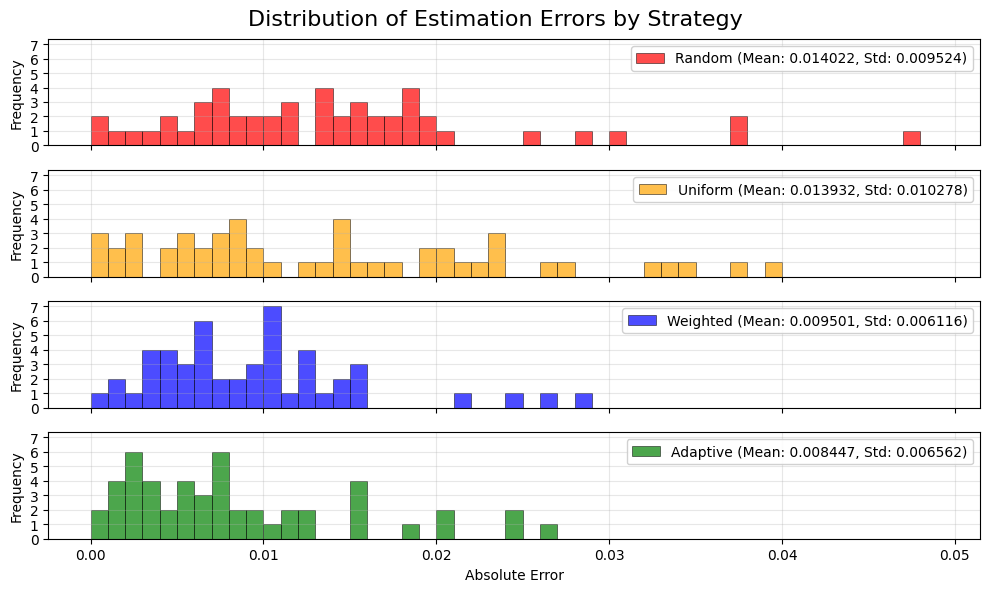

In [14]:
# Plot results with separate subplots (squashed aspect ratio)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

colors = {
    'Random': 'red',    
    'Uniform': 'orange',
    'Weighted': 'blue',
    'Adaptive': 'green'    
}

strategies = ['Random', 'Uniform', 'Weighted', 'Adaptive']

# First pass: calculate all histograms to find the maximum bar height
bins = np.arange(0.0, 0.05, 0.001)
max_height = 0

for strategy in strategies:
    values = results[strategy]
    errors = np.abs(np.array(values) - e_exact)
    counts, _ = np.histogram(errors, bins=bins)
    max_height = max(max_height, np.max(counts))

# Second pass: plot with consistent y-axis limits
for i, strategy in enumerate(strategies):
    values = results[strategy]
    errors = np.abs(np.array(values) - e_exact)
    
    # Plot histogram in the corresponding subplot
    axes[i].hist(errors, bins=bins, 
                 color=colors[strategy], alpha=0.7, edgecolor='black', linewidth=0.5,
                 label=strategy)
    
    # Add statistics as legend
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
    
    # Set aspect ratio and y-axis limits
    axes[i].set_aspect(aspect='auto')
    axes[i].set_ylim(0, max_height * 1.05)  # Add 5% padding at top
    
    # Set integer y-ticks
    axes[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Add legend with strategy name and statistics
    axes[i].legend([f'{strategy} (Mean: {mean_error:.6f}, Std: {std_error:.6f})'], 
                   loc='upper right', framealpha=0.9)

# Set common x-label only on the bottom subplot
axes[-1].set_xlabel('Absolute Error')

# Add overall title with more space
fig.suptitle('Distribution of Estimation Errors by Strategy', fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Add space between suptitle and subplots
plt.show()

Finally, we'll plot the actual shot allocation for the different strategies.

In [15]:
def visualize_shot_allocation_comparison(strategies, allocations, total_shots):
    """
    Visualize different shot allocation strategies for comparison.
    
    Args:
        strategies (list): Names of the strategies to compare
        allocations (list): List of shot allocations for each strategy
        total_shots (int): Total number of shots used
    """
    plt.figure(figsize=(12, 6))
    
    # Create a bar chart for each strategy
    x = np.arange(len(allocations[0]))
    width = 0.8 / len(strategies)
    
    for i, (strategy, allocation) in enumerate(zip(strategies, allocations)):
        plt.bar(x + i*width - 0.4 + width/2, allocation, width, 
                label=strategy, alpha=0.7, color = colors[strategy])
    
    plt.xlabel('Measurement Group')
    plt.ylabel('Number of Shots')
    plt.title(f'Comparison of Shot Allocation Strategies (Total: {total_shots} shots)')
    plt.xticks(x, [f'Group {i+1}' for i in x])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add percentages on top of each bar
    for i, (strategy, allocation) in enumerate(zip(strategies, allocations)):
        for j, shots in enumerate(allocation):
            percentage = 100 * shots / total_shots
            plt.text(j + i*width - 0.4 + width/2, shots + 5, 
                     f'{percentage:.1f}%', ha='center', fontsize=8)

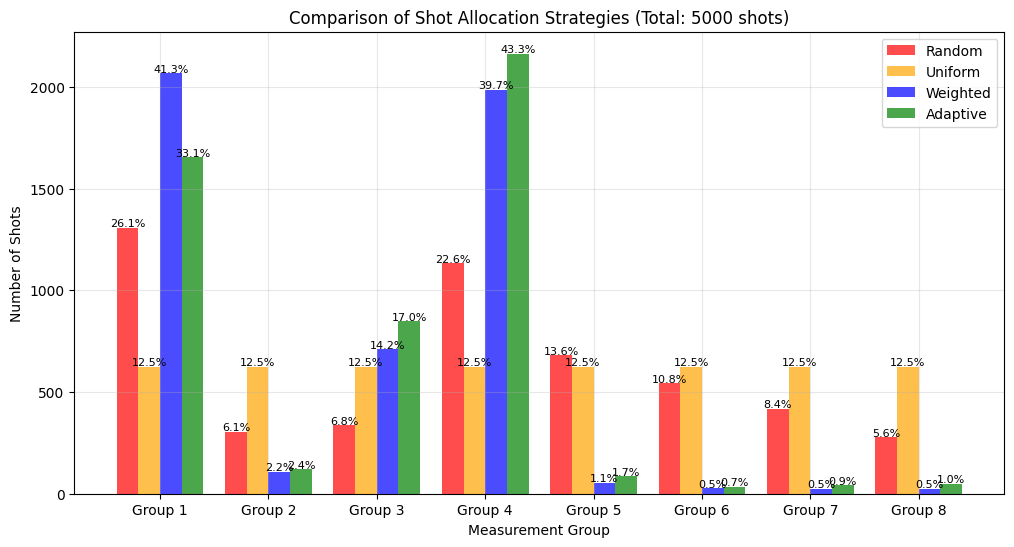

In [16]:
visualize_shot_allocation_comparison([strategy for strategy in results.keys()], [random_shots, uniform_shots, weighted_shots, estimator.shots], sum(uniform_shots))

### 6.1 A More Detailed Comparison of the Weighted and Adaptive Shot-Allocation Strategies

As shown in the plot above (except in rare cases where the randomly generated state significantly reduces the weighted strategy’s accuracy—similar to what we observed in Part 1 of this notebook series), the performance of the adaptive and weighted shot-allocation strategies appears quite similar.

To obtain more robust statistical insights, we conducted the following experiment:

- Using the same setup as in this notebook, we compared the weighted and adaptive shot-allocation strategies over **2,000** randomly generated quantum states.
- For each state, the expectation value was estimated using both strategies. Each estimate was averaged over **3** independent runs.
- We computed the **Relative Percentage Error (RPE)** for each strategy using the formula:  
  $$
  \text{RPE} = \frac{|\mathbb{E}_{\text{estimated}} - \mathbb{E}_{\text{exact}}|}{|\mathbb{E}_{\text{exact}}|} \times 100
  $$
- To avoid numerical instability, any state for which the absolute value of $\mathbb{E}_{\text{exact}}$ was less than **0.01** was excluded, and the trial was repeated with a new random state.

The results, summarized in the table below, indicate that the adaptive shot-allocation strategy performs statistically better:

| Strategy  | Mean RPE | RPE Std Dev | Median RPE |
|-----------|----------:|-------------:|-------------:|
| Adaptive  | 2.7949    | 5.4857       | 1.1790       |
| Weighted  | 2.9329    | 5.5025       | 1.2659       |

A histogram comparing the RPE distributions is shown below. *(Note: RPE values above **25%** are not displayed for clarity.)*
![Comparison of the weighted and adaptive strategies over 2000 randomly generated states](img/BeH_4q_binwidth1_maxrpe25.png)

## 7. Conclusion

In this notebook, we've explored adaptive shot allocation for expectation value calculations in quantum computing and demonstrated its advantages over static strategies. We observed that adaptive shot allocation consistently outperforms simple strategies like uniform or random shot-allocation. We also show that the accuracy of the adaptive approach rivals or exceeds that of the widely-adopted coefficient-weighted strategy, without suffering from any of its known drawbacks.

The adaptive shot allocation strategy has important practical implications for quantum algorithms like VQE, as the resource efficiency it provides (achieving similar precision with fewer total shots) could translate to faster convergence (reduced number of iterations, due to better accuracy for fixed number of shots) and, ultimately, wider applicability of the algorithm.

As quantum hardware continues to improve, efficient shot allocation will become increasingly important for making the most of available quantum resources.